### Tuning hyper-paremter of occipital cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  8 files
Extracted: 8 files


In [5]:
# Importing in neghbouring cells info (numbers)

with open(nnb_path + nnb_training) as f: 
    nb_mylist= f.read().splitlines()
    
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 8  NUMBER OF neighbouring cells files
Extracted: 8 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
with open(hema_path + hema_training) as f: 
    hema_mylist= f.read().splitlines()
    
print("Read in:",len(hema_mylist),"hema files")    


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 8 hema files
Extracted: 8 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                   NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True]


In [9]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [10]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True]
(420654, 56)


### Putting the slides together 

In [11]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI']) 
dat.head()


(1031543, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um,NN_110_um,NN_120_um,NN_130_um,NN_140_um,NN_150_um
0,721703.svs,Unlabelled,23317.2,303.63,0.8626,24.0212,17.8053,0.9522,1.0000,6.4203,...,8,8,9,12,17,18,21,27,31,34
1,721703.svs,Unlabelled,23117.0,305.14,0.6539,28.8830,22.6611,0.7068,0.9962,8.9267,...,12,15,18,25,30,36,40,42,47,52
2,721703.svs,Unlabelled,23301.3,310.54,0.8008,57.8022,28.1008,0.9199,1.0000,10.7756,...,9,10,14,17,20,23,27,29,35,39
3,721703.svs,Unlabelled,23204.2,309.59,0.8541,29.3505,21.2158,0.8194,0.9948,7.9087,...,10,13,21,30,34,37,44,47,56,61
4,721703.svs,Unlabelled,23098.8,310.98,0.7954,25.5138,19.5136,0.8420,1.0000,7.4015,...,10,14,19,24,31,37,39,45,50,56


### Extracting relevant cell classes

In [12]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

unlabelled    1029835
neuron            476
oligo             445
ignore            244
astro             220
epithelial        159
endo              123
ambiguous          33
fragmented          6
region              2
Name: Class, dtype: int64

In [13]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'endo')| (dat2['Class'] == 'fragmented')
          | (dat2['Class'] == 'ignore')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

neuron        476
oligo         445
ignore        244
astro         220
epithelial    159
endo          123
fragmented      6
Name: Class, dtype: int64

In [14]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [15]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [16]:
data['Class'].value_counts()

Others    532
Neuron    476
Oligo     445
Astro     220
Name: Class, dtype: int64

In [17]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/occipital_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [18]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [19]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l[training_features]
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (1673, 44)


In [20]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8900,19.8128,15.8949,0.9855,1.0000,5.2491,4.8900,175.3026,47.1113,0.9925,...,0,0,0,1,5,8,12,16,22,23
1,0.7042,16.1802,16.5761,0.7400,0.9797,6.9006,2.8992,129.4477,44.7169,0.8135,...,0,0,0,2,3,6,8,10,17,21
2,0.9050,40.6065,23.0532,0.9602,1.0000,8.2325,6.4008,170.7491,49.0544,0.8917,...,0,2,2,3,5,5,12,15,17,20
3,0.8948,13.7914,13.2936,0.9807,1.0000,4.3656,4.0313,66.5980,30.8291,0.8805,...,1,2,3,4,4,7,11,15,17,21
4,0.8426,31.2085,20.1525,0.9657,1.0000,7.0218,5.7947,191.4056,50.2637,0.9520,...,0,1,1,4,4,11,12,15,18,23


### Hyperparameter tuning - random forest

In [21]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

In [22]:
# # Create the random grid 

rf_random = GridSearchCV(pipeline_cell_linearSVM_prob,
                         param_grid=grid_linearSVM, 
                        cv=10,
                        refit='PR_AUC', # use this metric to evaluate performance of parameters 
                      scoring={'PR_AUC':precision_recall_auc,
                          'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                              'balanced_accuracy':'balanced_accuracy',
                               'f1_weighted':'f1_weighted',
                               'Astro_accuracy': astro_acc,
                               'Neuron_accuracy':neuron_acc,
                               'Oligo_accuracy':oligo_acc,
                               'Others_accuracy':others_acc,
                               'A_as_N':A_as_N,
                               'A_as_O':A_as_O,
                               'A_as_Others':A_as_Others,
                               'N_as_A':N_as_A,
                               'N_as_O':N_as_O,
                               'N_as_Others':N_as_Others,
                               'O_as_A':O_as_A,
                               'O_as_N':O_as_N,
                               'O_as_Others':O_as_Others,
                               'Others_as_A':Others_as_A,
                               'Others_as_N':Others_as_N,
                               'Others_as_O':Others_as_O
                              })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


0.8251779954232428
{'clf__C': 10, 'clf__class_weight': 'balanced', 'selector__n_features_to_select': 30}


In [24]:
# # Digging into more details 
print("PR-AUC:",
      rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

PR-AUC: 82.51779954232428
Balanced accuracy: 77.11403096602314
F1_weighted: 78.16283539956926
Astrocyte accuracy: 73.18181818181819
Neuron accuracy: 76.26773049645391
Oligo accuracy: 81.74242424242424
Others accuracy: 77.26415094339623
Classified A as N: 13.181818181818183
Classified A as O: 8.636363636363635
Classified A as Others: 5.0
Classified N as A: 16.59131205673759
Classified N as O: 0.4166666666666667
Classified N as Others: 6.724290780141843
Classified O as A: 11.045454545454545
Classified O as N: 0.0
Classified O as Others: 7.212121212121211
Classified Others as A: 5.276030747728861
Classified Others as N: 7.693920335429769
Classified Others as O: 9.765897973445144


In [25]:
# save object using joblib
joblib.dump(rf_random, 'occipital_prob_linear_SVM_gridSearch.sav')

['occipital_prob_linear_SVM_gridSearch.sav']

## Manual cross validation, using PR curves

In [26]:
occipital_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=SVC(random_state=42,
                                   kernel='linear'),
        n_features_to_select=30)),
    ('clf', SVC(
        random_state=42,
        kernel='linear',
        C=10,
        class_weight='balanced',
        probability=True))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=occipital_classifier_hyperparams)
model.find_bestparameters(X=X_train,
                          Y=y_train)


In [34]:
model.best_parameters

{0: (0.2930580463535878,
  0.6598449934408971,
  0.6027293365345757,
  0.7818181818181819),
 1: (0.40687946415091314,
  0.8577390324150784,
  0.8320814465178072,
  0.8909131205673757),
 2: (0.4883970929607314,
  0.8674232107402678,
  0.8648132644595522,
  0.8740404040404041),
 3: (0.4145137962230243,
  0.8365717813426983,
  0.8337604108337165,
  0.8419636617749825)}

In [35]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=X_train,
                          Y=y_train,
                          X_location = X_train_l)

In [36]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("Astro accuracy",final_cm_t[0][0])
print("Neuron accuracy",final_cm_t[1][1])
print("Oligo accuracy",final_cm_t[2][2])
print("Oligo accuracy",final_cm_t[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reportsT])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reportsT])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reportsT])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reportsT])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 79.15313136340832
Macro avg F1  78.50669125929645
Weighted avg F1  81.30274599810991
--------------------------
[[126  27  14  15]
 [ 33 351   2  31]
 [ 40   0 352  37]
 [ 17  32  42 417]]
[[69.23076923 14.83516484  7.69230769  8.24175824]
 [ 7.91366906 84.17266187  0.47961631  7.43405276]
 [ 9.32400932  0.         82.05128205  8.62470862]
 [ 3.34645669  6.2992126   8.26771654 82.08661417]]
--------------------------
Astro accuracy 69.23076923076923
Neuron accuracy 84.17266187050359
Oligo accuracy 82.05128205128204
Oligo accuracy 82.08661417322834
------------------------------
Astro f1-score  62.87865251044862
Astro precision  58.8935696687413
Astro recall  68.63279857397504
--------------------------
Neuron f1-score  85.03295117938919
Neuron precision  86.31804007884249
Neuron recall  84.15919748209078
--------------------------
Oligo f1-score  83.44430081864294
Oligo precision  85.99569170053893
Oligo recall  81.74717760338861
---------------

In [37]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [38]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 77.11403096602314
Macro avg F1  75.7409547463896
Weighted avg F1  78.16283539956926
--------------------------
[[161  29  19  11]
 [ 79 363   2  32]
 [ 49   0 364  32]
 [ 28  41  52 411]]
[[73.18181818 13.18181818  8.63636364  5.        ]
 [16.59663866 76.2605042   0.42016807  6.72268908]
 [11.01123596  0.         81.79775281  7.19101124]
 [ 5.26315789  7.70676692  9.77443609 77.2556391 ]]
--------------------------
Astro accuracy 73.18181818181819
Neuron accuracy 76.26050420168067
Oligo accuracy 81.79775280898876
Others accuracy 77.25563909774436
------------------------------
Astro f1-score  60.243162376359706
Astro precision  51.676266262473156
Astro recall  73.18181818181819
--------------------------
Neuron f1-score  79.85470018523166
Neuron precision  84.674728314352
Neuron recall  76.26773049645391
--------------------------
Oligo f1-score  82.20801485736551
Oligo precision  83.41293951592974
Oligo recall  81.74242424242424
--------------------------
Others

In [40]:
# save object using joblib
joblib.dump(model, 'occipital_prob_linear_SVM_cv_results.sav')

['occipital_prob_linear_SVM_cv_results.sav']

Extracting information

In [41]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/Occipital/occipital_prob_linear_SVM_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [42]:
final_cm_t

array([[69.23076923, 14.83516484,  7.69230769,  8.24175824],
       [ 7.91366906, 84.17266187,  0.47961631,  7.43405276],
       [ 9.32400932,  0.        , 82.05128205,  8.62470862],
       [ 3.34645669,  6.2992126 ,  8.26771654, 82.08661417]])

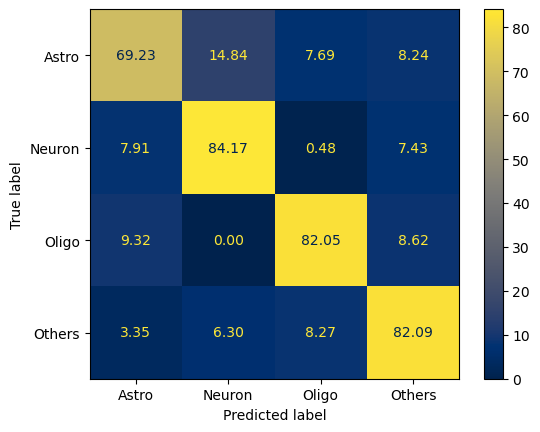

In [43]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [45]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  78.50669125929645
Macro avg F1 std  5.439465721854832
--------------------------
Macro avg precision 78.70763024081072
Macro avg precision std 5.139929690992737
--------------------------
Macro avg recall  79.15313136340832
Macro avg recall std 5.484236549947692


In [46]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  75.7409547463896
Macro avg F1 std  4.625971419976194
--------------------------
Macro avg precision 76.1103984433937
Macro avg precision std 4.265401550480628
--------------------------
Macro avg recall  77.11403096602314
Macro avg recall std 5.04623769797619


Plotting feature importance

In [48]:
import seaborn as sns

In [47]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/Occipital/occipital_prob_linear_SVM_gridSearch.sav')

In [49]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance_all = model_rf.best_estimator_.named_steps['clf'].coef_ # This we get  (n_classes * (n_classes - 1) / 2, n_features) as we have multiple classes
importance_av = np.mean(importance_all,axis=0) # So here, I just took a mean across all class comparisons
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance_av})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [50]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [51]:
f_importance_subset

,Feature,Importance
0,Detection probability,3.968957
5,Nucleus: Min diameter µm,3.081028
9,Cell: Max diameter µm,2.188986
3,Nucleus: Circularity,2.029974
7,Cell: Length µm,2.009349
18,Hematoxylin: Cytoplasm: Max,1.351876
26,Hematoxylin: Cell: Max,1.209746
21,Hematoxylin: Membrane: Median,1.203736
2,Nucleus: Length µm,1.069270
11,Nucleus/Cell area ratio,1.064135


<Axes: xlabel='Importance', ylabel='Feature'>

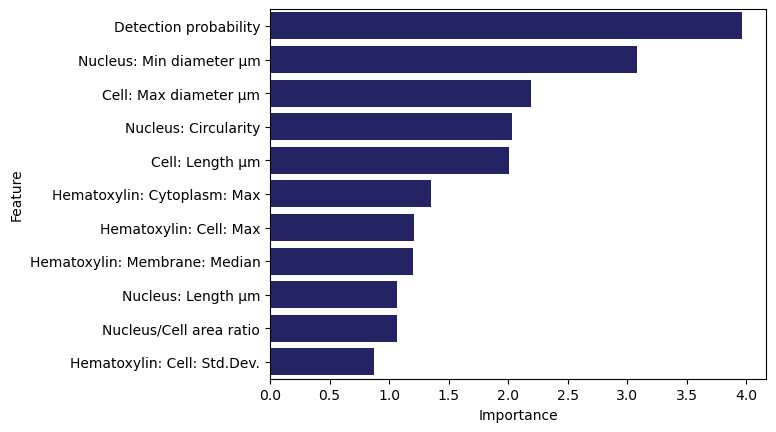

In [52]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [53]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [54]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

82.51779954232428
mean pr: 82.51779954232428
std pr: 4.746151323981131
